WELCOME.

To run this model, you will need:


*   A Google account
*   A web browser
*   A stable internet connection
*   An understanding of Python programming

Also, please ensure runtime is set to GPU. Go to Runtime -> Change Runtime Type -> Select GPU from drop-down menu and click Save

Make sure file_path is set the dataset you wish to train the model on (Twitter15 or Twitter16. Both accessible to download from GitLab repository)

Run the code cells in chronological order to ensure all the code runs as intended

In [1]:
!pip install transformers #Install Huggingface Transformer Library
!pip install transformers nlpaug  # Install nlpaug

# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertModel
from transformers import BertForSequenceClassification
import nlpaug.augmenter.word as naw

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import os
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np


# Create the data augmentation function using nlpaug library
def augment_text(text, method='synonym', n=1):
    if method == 'synonym':
        augmenter = naw.SynonymAug(aug_src='wordnet')
    elif method == 'swap':
        augmenter = naw.RandomWordAug(action="swap")
    elif method == 'delete':
        augmenter = naw.RandomWordAug()
    else:
        raise ValueError("Invalid augmentation method")
    
    augmented_texts = augmenter.augment(text, n=n)
    return [text] + augmented_texts

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset. Change to Twitter16Dataset, if necessary
file_path = 'Twitter15Dataset.csv'
df = pd.read_csv(file_path, names=["Label", "SourceID", "Tweet"], header=0)


# Define preprocessing functions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_special_characters(text):
    return re.sub(r'\W', ' ', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def tokenize(text):
    return text.split()

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Preprocess the dataset
df['Tweet'] = df['Tweet'].apply(remove_urls)
df['Tweet'] = df['Tweet'].apply(remove_mentions)
df['Tweet'] = df['Tweet'].apply(remove_special_characters)
df['Tweet'] = df['Tweet'].apply(tokenize)
df['Tweet'] = df['Tweet'].apply(remove_stopwords)
df['Tweet'] = df['Tweet'].apply(lemmatize)
df['Tweet'] = df['Tweet'].apply(lambda tokens: ' '.join(tokens))

# Encode the labels
label_mapping = {'unverified': 0, 'non-rumor': 1, 'TRUE': 2, 'FALSE': 3}
df['Label'] = df['Label'].map(label_mapping)

# Add the line to remove rows with missing labels
df = df.dropna(subset=['Label'])

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])

# Apply data augmentation
n_augmentations = 2
train_df['Augmented_Tweet'] = train_df['Tweet'].apply(lambda x: augment_text(x, method='synonym', n=n_augmentations))
train_df = train_df.explode('Augmented_Tweet').reset_index(drop=True)

# Save the preprocessed datasets to CSV files
train_df.to_csv('train_preprocessed.csv', index=False)
val_df.to_csv('val_preprocessed.csv', index=False)

# Vectorize the preprocessed text
# Create TF-IDF feature vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['Augmented_Tweet'])
X_val = vectorizer.transform(val_df['Tweet'])
y_train = train_df['Label']
y_val = val_df['Label']


# Train and evaluate the SVM model
svm_model = SVC(kernel='linear', C=1, probability=True, class_weight='balanced')
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_val)

svm_accuracy = accuracy_score(y_val, svm_y_pred)
svm_precision = precision_score(y_val, svm_y_pred, average='weighted')
svm_recall = recall_score(y_val, svm_y_pred, average='weighted')
svm_f1 = f1_score(y_val, svm_y_pred, average='weighted')

print("SVM Model:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")

# Train and evaluate the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_val)

lr_accuracy = accuracy_score(y_val, lr_y_pred)
lr_precision = precision_score(y_val, lr_y_pred, average='weighted')
lr_recall = recall_score(y_val, lr_y_pred, average='weighted')
lr_f1 = f1_score(y_val, lr_y_pred, average='weighted')


print("Logistic Regression Model:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


SVM Model:
Accuracy: 0.8423
Precision: 0.8460
Recall: 0.8423
F1 Score: 0.8436
Logistic Regression Model:
Accuracy: 0.8389
Precision: 0.8419
Recall: 0.8389
F1 Score: 0.8400


In [2]:
df.head()

,Label,SourceID,Tweet
0,0,7.310000e+17,ca kkk grand wizard endorses neverhillary trum...
1,0,7.150000e+17,open letter trump voter top strategist turned ...
2,1,6.920000e+17,america nation second chance new reform solita...
3,1,6.930000e+17,brandon marshall visit offer advice support br...
4,2,5.510000e+17,rip elly may clampett sad learn beverlyhillbil...


In [3]:
df.tail()

,Label,SourceID,Tweet
1485,1,6.920000e+17,announced new reform address overuse solitary ...
1486,0,7.600000e+17,school satan club URL
1487,0,5.000000e+17,breaking news according document released pres...
1488,3,5.230000e+17,ebola vaccine URL news today
1489,0,5.240000e+17,concerned airport passenger suit homemade hazm...


In [4]:
def evaluate_SVMandLRmodel(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)  # Changed from 'weighted' to None
    recall = recall_score(y_true, y_pred, average=None)  # Changed from 'weighted' to None
    f1 = f1_score(y_true, y_pred, average=None)  # Changed from 'weighted' to None

    print(f"{model_name} Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    return metrics


# Evaluate the SVM model
print("\nSVM Model Evaluation:")
svm_metrics = evaluate_SVMandLRmodel("SVM", y_val, svm_y_pred)

# Evaluate the Logistic Regression model
print("\nLogistic Regression Model Evaluation:")
lr_metrics = evaluate_SVMandLRmodel("Logistic Regression", y_val, lr_y_pred)



SVM Model Evaluation:
SVM Model:
Accuracy: 0.8423
Precision:  [0.85526316 0.73417722 0.95714286 0.83561644]
Recall:  [0.86666667 0.78378378 0.89333333 0.82432432]
F1 Score:  [0.86092715 0.75816993 0.92413793 0.82993197]

Logistic Regression Model Evaluation:
Logistic Regression Model:
Accuracy: 0.8389
Precision:  [0.86666667 0.73417722 0.92957746 0.83561644]
Recall:  [0.86666667 0.78378378 0.88       0.82432432]
F1 Score:  [0.86666667 0.75816993 0.90410959 0.82993197]


In [5]:
# Define the RumourDataset class
class RumorDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Tweet']
        label = self.data.iloc[idx]['Label']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(int(label), dtype=torch.long)
        }

# Load the ConfliBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("snowood1/ConfliBERT-scr-cased")
model = AutoModelForSequenceClassification.from_pretrained("snowood1/ConfliBERT-scr-cased", num_labels=4) 

# Add dropout layer
model.classifier.dropout = nn.Dropout(0.1)
# Define constants
MAX_LENGTH = 128
BATCH_SIZE = 32

# Create DataLoader for the training and validation datasets
train_dataset = RumorDataset(train_df, tokenizer, MAX_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = RumorDataset(val_df, tokenizer, MAX_LENGTH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Some weights of the model checkpoint at snowood1/ConfliBERT-scr-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snowood1/Confli

TRAIN the ConfliIBERT MODEL

In [6]:
#Function to train confliBERT model
def train_model(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

#Function to evaluate confliBERT model
def eval_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    loss_fn = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    return total_loss / len(dataloader), classification_report(all_labels, all_preds, output_dict=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0001
WARMUP_STEPS = 300
PATIENCE = 3


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=EPOCHS * len(train_dataloader))

best_model_dir = "best_rumor_detection_model"
if not os.path.exists(best_model_dir):
    os.makedirs(best_model_dir)

best_val_loss = float("inf")
no_improvement_epochs = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
    val_loss, val_report = eval_model(model, val_dataloader, device)
    print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
    print(f"Val report: {val_report}")

    # Save the best model based on validation performance
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        # Save the model
        model.save_pretrained(best_model_dir)
        tokenizer.save_pretrained(best_model_dir)
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= PATIENCE:
            print("Early stopping triggered")
            break
            
# Get ConfliBERT model predictions on the validation set
confliBERT_y_pred = []
with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        confliBERT_y_pred.extend(preds.detach().cpu().numpy())
# Convert predictions to a NumPy array
confliBERT_y_pred = np.array(confliBERT_y_pred)

Epoch 1/10
Train loss: 1.3812, Val loss: 1.3645
Val report: {'0': {'precision': 0.5, 'recall': 0.06666666666666667, 'f1-score': 0.11764705882352941, 'support': 75}, '1': {'precision': 0.28888888888888886, 'recall': 0.8783783783783784, 'f1-score': 0.43478260869565216, 'support': 74}, '2': {'precision': 0.7058823529411765, 'recall': 0.16, 'f1-score': 0.2608695652173913, 'support': 75}, '3': {'precision': 0.3695652173913043, 'recall': 0.22972972972972974, 'f1-score': 0.2833333333333333, 'support': 74}, 'accuracy': 0.33221476510067116, 'macro avg': {'precision': 0.4660841148053424, 'recall': 0.3336936936936937, 'f1-score': 0.27415814151747653, 'support': 298}, 'weighted avg': {'precision': 0.46700261857490794, 'recall': 0.33221476510067116, 'f1-score': 0.2735883440040737, 'support': 298}}
Epoch 2/10
Train loss: 1.1281, Val loss: 0.9282
Val report: {'0': {'precision': 0.7872340425531915, 'recall': 0.49333333333333335, 'f1-score': 0.6065573770491803, 'support': 75}, '1': {'precision': 0.5820

In [7]:
# Load the pretrained model
best_model_dir = "best_rumor_detection_model"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

# Load the trained model
best_model = BertForSequenceClassification.from_pretrained(best_model_dir)
best_model.to(device)
best_model.eval()

# Define prediction function
def predict_rumor_status(text, model, tokenizer, max_length):
    # Encode the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Make prediction
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

    # Map predictions to labels
    label_mapping = {
        0: "true-rumour",
        1: "false-rumour",
        2: "unverified-rumour",
        3: "non-rumour",
    }
    return label_mapping[preds.item()]

# Test the prediction function with an example text
example_text = "Breaking news: Giant pandas can now fly!"
predicted_status = predict_rumor_status(example_text, best_model, tokenizer, MAX_LENGTH)
print(f"Predicted rumor status: {predicted_status}")

Predicted rumor status: false-rumour


In [8]:
# Create DataLoader for the test dataset
test_dataset = RumorDataset(test_df, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate the best model on the test dataset
test_loss, test_report = eval_model(best_model, test_dataloader, device)
print(f"Test loss: {test_loss:.4f}")
print(f"Test report: {test_report}")

Test loss: 0.9608
Test report: {'0': {'precision': 0.7162162162162162, 'recall': 0.7066666666666667, 'f1-score': 0.7114093959731544, 'support': 75}, '1': {'precision': 0.5904761904761905, 'recall': 0.8266666666666667, 'f1-score': 0.6888888888888889, 'support': 75}, '2': {'precision': 0.8611111111111112, 'recall': 0.8378378378378378, 'f1-score': 0.8493150684931507, 'support': 74}, '3': {'precision': 0.9361702127659575, 'recall': 0.5945945945945946, 'f1-score': 0.7272727272727273, 'support': 74}, 'accuracy': 0.7416107382550335, 'macro avg': {'precision': 0.7759934326423689, 'recall': 0.7414414414414414, 'f1-score': 0.7442215201569804, 'support': 298}, 'weighted avg': {'precision': 0.7751702968752805, 'recall': 0.7416107382550335, 'f1-score': 0.7439257323870074, 'support': 298}}


In [9]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Per label performance:")
    print(classification_report(all_labels, all_preds))
    
# Evaluate the model on validation dataset
evaluate_model(best_model, val_dataloader, device)


Evaluation:
Accuracy: 0.7987
Precision: 0.8340
Recall: 0.7987
F1 Score: 0.8032
Per label performance:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        75
           1       0.60      0.86      0.71        74
           2       0.93      0.92      0.93        75
           3       0.94      0.66      0.78        74

    accuracy                           0.80       298
   macro avg       0.83      0.80      0.80       298
weighted avg       0.83      0.80      0.80       298



In [10]:
def evaluate_test(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Per label performance:")
    print(classification_report(all_labels, all_preds))
    
# Evaluate the model on test dataset (unseen data)
evaluate_test(best_model, test_dataloader, device)


Evaluation:
Accuracy: 0.7416
Precision: 0.7752
Recall: 0.7416
F1 Score: 0.7439
Per label performance:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71        75
           1       0.59      0.83      0.69        75
           2       0.86      0.84      0.85        74
           3       0.94      0.59      0.73        74

    accuracy                           0.74       298
   macro avg       0.78      0.74      0.74       298
weighted avg       0.78      0.74      0.74       298



In [11]:
#Use for Twitter15
example_texts = [
    "Breaking news: Giant pandas can now fly!",
    "A new scientific study shows that drinking coffee can reduce the risk of heart diseases.",
    "The US government has announced a new stimulus package to support small businesses.",
    "rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away.",
    "islamic tribunal using sharia law in texas has been confirmed URL breitbartnews #a4a",
    "‘keep it,’ says simone biles throwing gold medal to adoring men's gymnastics team #rio2016",
]

for text in example_texts:
    predicted_status = predict_rumor_status(text, model, tokenizer, MAX_LENGTH)
    print(f"Text: {text}\nPredicted rumor status: {predicted_status}\n")


Text: Breaking news: Giant pandas can now fly!
Predicted rumor status: false-rumour

Text: A new scientific study shows that drinking coffee can reduce the risk of heart diseases.
Predicted rumor status: false-rumour

Text: The US government has announced a new stimulus package to support small businesses.
Predicted rumor status: false-rumour

Text: rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away.
Predicted rumor status: unverified-rumour

Text: islamic tribunal using sharia law in texas has been confirmed URL breitbartnews #a4a
Predicted rumor status: non-rumour

Text: ‘keep it,’ says simone biles throwing gold medal to adoring men's gymnastics team #rio2016
Predicted rumor status: false-rumour



In [9]:
#Use for Twitter16
example_texts = [
    "Breaking news: Giant pandas can now fly!", #FALSE
    "A new scientific study shows that drinking coffee can reduce the risk of heart diseases.", #TRUE
    "The US government has announced a new stimulus package to support small businesses.", #TRUE
    "the canadian soldier killed in today's ottawa shooting is cpl. nathan cirillo, a family source told cnn. live blog: URL", #TRUE
    "#wakeupamerica🇺🇸 who needs a #gun registry when #obama has all your personal information URL URL", #FALSE
    "russian olympic officials concerned after learning team’s clean urine reservoir almost empty URL URL", #NON-RUMOUR
]

for text in example_texts:
    predicted_status = predict_rumor_status(text, model, tokenizer, MAX_LENGTH)
    print(f"Text: {text}\nPredicted rumor status: {predicted_status}\n")


Text: Breaking news: Giant pandas can now fly!
Predicted rumor status: unverified-rumour

Text: A new scientific study shows that drinking coffee can reduce the risk of heart diseases.
Predicted rumor status: false-rumour

Text: The US government has announced a new stimulus package to support small businesses.
Predicted rumor status: false-rumour

Text: the canadian soldier killed in today's ottawa shooting is cpl. nathan cirillo, a family source told cnn. live blog: URL
Predicted rumor status: unverified-rumour

Text: #wakeupamerica🇺🇸 who needs a #gun registry when #obama has all your personal information URL URL
Predicted rumor status: non-rumour

Text: russian olympic officials concerned after learning team’s clean urine reservoir almost empty URL URL
Predicted rumor status: false-rumour



In [12]:
class EnsembleClassifier:
    def __init__(self, svm_model, lr_model, confliBERT_model, tokenizer, device):
        self.svm_model = svm_model
        self.lr_model = lr_model
        self.confliBERT_model = confliBERT_model
        self.tokenizer = tokenizer
        self.device = device

    def _predict_confliBERT(self, text, max_length=128):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)
            outputs = self.confliBERT_model(input_ids, attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
        return preds.item()

    def predict(self, X):
        # For ConfliBERT predictions
        confliBERT_preds = [self._predict_confliBERT(text) for text in X]

        # For SVM and LR predictions
        X_tfidf = vectorizer.transform(X)
        svm_preds = self.svm_model.predict_proba(X_tfidf)
        lr_preds = self.lr_model.predict_proba(X_tfidf)

        # Combine predictions
        ensemble_preds = []
        for i in range(len(X)):
            avg_preds = (svm_preds[i] + lr_preds[i]) / 2
            avg_preds[confliBERT_preds[i]] += 0.5
            ensemble_preds.append(np.argmax(avg_preds))

        return np.array(ensemble_preds)


In [13]:
# Train and evaluate an ensemble model using SVM, Logistic Regression, and ConfliBERT
ensemble_model = EnsembleClassifier(svm_model, lr_model, best_model, tokenizer, device)

ensemble_y_pred = ensemble_model.predict(val_df['Tweet'])

ensemble_accuracy = accuracy_score(y_val, ensemble_y_pred)
ensemble_precision = precision_score(y_val, ensemble_y_pred, average='weighted')
ensemble_recall = recall_score(y_val, ensemble_y_pred, average='weighted')
ensemble_f1 = f1_score(y_val, ensemble_y_pred, average='weighted')

print("Ensemble Model (SVM + Logistic Regression + ConfliBERT):")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Precision: {ensemble_precision:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"F1 Score: {ensemble_f1:.4f}")

# Print the classification report for each class
class_labels = ['UR', 'NR', 'TR', 'FR']
print("\nClassification Report:")
print(classification_report(y_val, ensemble_y_pred, target_names=class_labels))


Ensemble Model (SVM + Logistic Regression + ConfliBERT):
Accuracy: 0.8490
Precision: 0.8653
Recall: 0.8490
F1 Score: 0.8526

Classification Report:
              precision    recall  f1-score   support

          UR       0.88      0.81      0.85        75
          NR       0.68      0.86      0.76        74
          TR       0.96      0.92      0.94        75
          FR       0.94      0.80      0.86        74

    accuracy                           0.85       298
   macro avg       0.86      0.85      0.85       298
weighted avg       0.87      0.85      0.85       298



In [14]:
#Use for Twitter15
def ensemble_predictions(example_texts, ensemble_model):
    label_mapping = {0: "unverified", 1: "non-rumor", 2: "TRUE", 3: "FALSE"}

    predictions = ensemble_model.predict(example_texts)

    for text, pred in zip(example_texts, predictions):
        pred_label = label_mapping[pred]
        print(f"Text: {text}\nEnsemble predicted rumor status: {pred_label}\n")

# Call the ensemble prediction function with the example texts
example_texts = [
    "Breaking news: Giant pandas can now fly!",
    "A new scientific study shows that drinking coffee can reduce the risk of heart diseases.",
    "The US government has announced a new stimulus package to support small businesses.",
    "rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away.",
    "islamic tribunal using sharia law in texas has been confirmed URL breitbartnews #a4a",
    "‘keep it,’ says simone biles throwing gold medal to adoring men's gymnastics team #rio2016",
]

ensemble_predictions(example_texts, ensemble_model)


Text: Breaking news: Giant pandas can now fly!
Ensemble predicted rumor status: non-rumor

Text: A new scientific study shows that drinking coffee can reduce the risk of heart diseases.
Ensemble predicted rumor status: non-rumor

Text: The US government has announced a new stimulus package to support small businesses.
Ensemble predicted rumor status: non-rumor

Text: rip elly may clampett: so sad to learn #beverlyhillbillies star donna douglas has passed away.
Ensemble predicted rumor status: TRUE

Text: islamic tribunal using sharia law in texas has been confirmed URL breitbartnews #a4a
Ensemble predicted rumor status: FALSE

Text: ‘keep it,’ says simone biles throwing gold medal to adoring men's gymnastics team #rio2016
Ensemble predicted rumor status: non-rumor



In [ ]:
#Use for Twitter16
def ensemble_predictions(example_texts, ensemble_model):
    label_mapping = {0: "unverified", 1: "non-rumor", 2: "TRUE", 3: "FALSE"}

    predictions = ensemble_model.predict(example_texts)

    for text, pred in zip(example_texts, predictions):
        pred_label = label_mapping[pred]
        print(f"Text: {text}\nEnsemble predicted rumor status: {pred_label}\n")

# Call the ensemble prediction function with the example texts
example_texts = [
    "Breaking news: Giant pandas can now fly!", #FALSE
    "A new scientific study shows that drinking coffee can reduce the risk of heart diseases.", #TRUE or non-rumour
    "The US government has announced a new stimulus package to support small businesses.", #TRUE or non-rumour
    "the canadian soldier killed in today's ottawa shooting is cpl. nathan cirillo, a family source told cnn. live blog: URL", #TRUE
    "#wakeupamerica🇺🇸 who needs a #gun registry when #obama has all your personal information URL URL", #FALSE
    "russian olympic officials concerned after learning team’s clean urine reservoir almost empty URL URL", #NON-RUMOUR
]

ensemble_predictions(example_texts, ensemble_model)

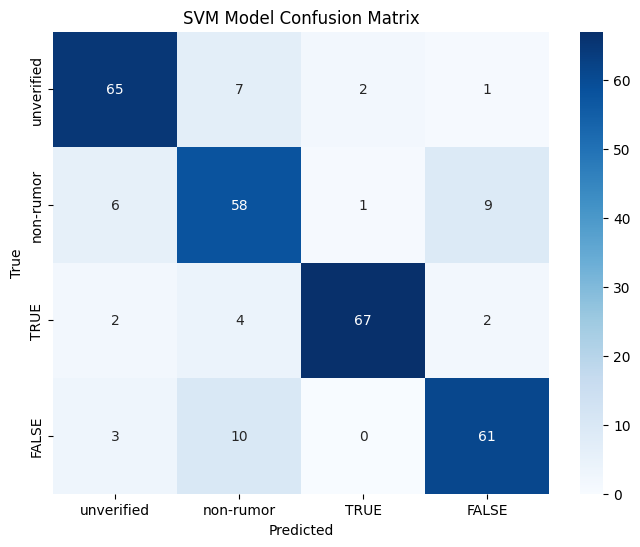

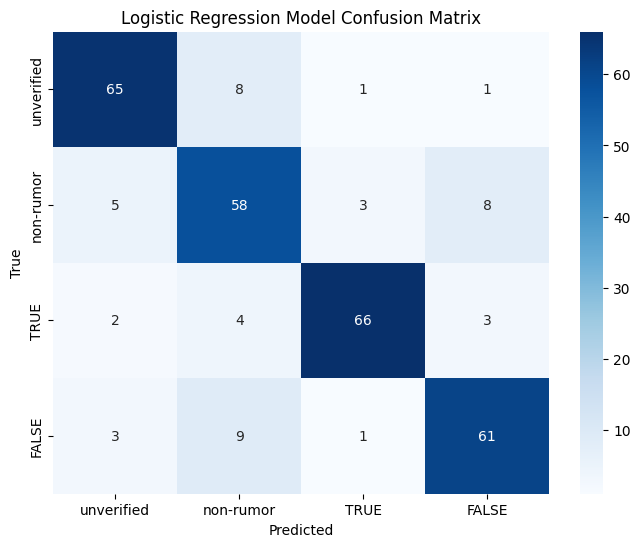

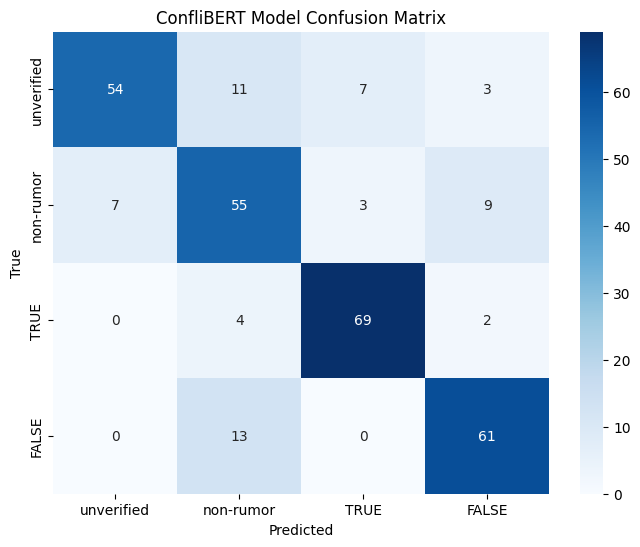

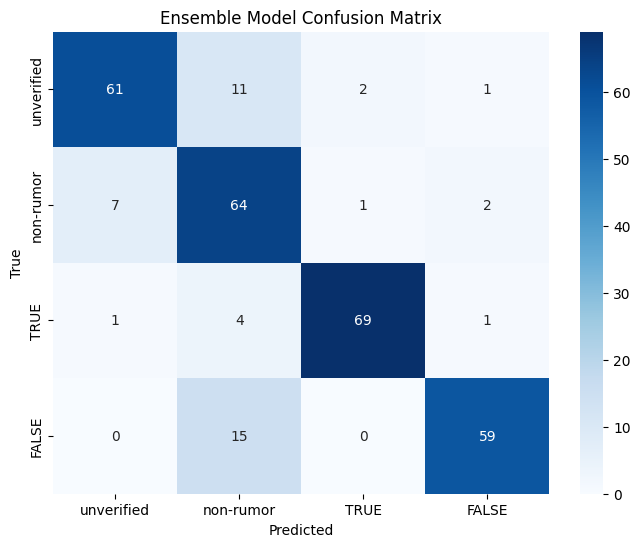

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

class_labels = ['unverified', 'non-rumor', 'TRUE', 'FALSE']

# Plot confusion matrices
plot_confusion_matrix(y_val, svm_y_pred, class_labels, 'SVM Model Confusion Matrix')
plot_confusion_matrix(y_val, lr_y_pred, class_labels, 'Logistic Regression Model Confusion Matrix')
plot_confusion_matrix(y_val, confliBERT_y_pred, class_labels, 'ConfliBERT Model Confusion Matrix')
plot_confusion_matrix(y_val, ensemble_y_pred, class_labels, 'Ensemble Model Confusion Matrix')
